In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Initial required libraries

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Loading the Dataset
*About the data:* <br>
The data is an twitter comments of various US Airlines having sentiments of the tweet: positive, negative or neutral.

*Columns:* <br>


1.   text: The actual tweet
2.   airline: Name of the airline tweeted about
3. latitude, longitude: Location of the tweet
4. airline_sentiment_confidence : Confidence of the sentiment classification of the tweet
5. airline_sentiment: Sentiment of the tweet


In [9]:
#intializing global variables
data = pd.read_csv('https://raw.githubusercontent.com/anjaliasha123/Data_Visualization_projects/master/Streamlit_python/Tweets.csv', usecols=['text','airline_sentiment'])
print(data.text.head(2))
print(data.airline_sentiment.value_counts())
num_of_categories = 2363
data = data.reindex(np.random.permutation(data.index))
positive = data[data['airline_sentiment'] == 'positive'][:num_of_categories]
negative = data[data['airline_sentiment'] == 'negative'][:num_of_categories]
neutral = data[data['airline_sentiment'] == 'neutral'][:num_of_categories]
data = pd.concat([positive,negative,neutral], ignore_index=True)
data = data.reindex(np.random.permutation(data.index))
print(data.shape)
data.to_csv('dataset.csv')


0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
Name: text, dtype: object
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64
(7089, 2)


In [16]:
data.head(5)

,airline_sentiment,text,LABEL
5755,neutral,@united Educate Bohol is a 501(c)(3) w/all vol...,2
2633,negative,@JetBlue I'm disappointed my flight was Cancel...,1
5087,neutral,@VirginAmerica are flights leaving Dallas for ...,2
875,positive,@united provide a voucher for one of my custom...,0
4436,negative,@SouthwestAir no had to rebook my flight mysel...,1


In [22]:
len(max(data.text.values, key=len))

186

In [10]:
data['LABEL'] = 0
data.loc[data.airline_sentiment == 'positive', 'LABEL'] = 0
data.loc[data.airline_sentiment == 'negative', 'LABEL'] = 1
data.loc[data.airline_sentiment == 'neutral', 'LABEL'] = 2
print(data['LABEL'][:10])

5755    2
2633    1
5087    2
875     0
4436    1
4615    1
5106    2
4139    1
1411    0
1187    0
Name: LABEL, dtype: int64


In [11]:
dataCopy = data

For the purpose of this project, we are considering only the 'text' column of the Xdata

#MOST COMMON VARIABLES:


*   most_common : for the most common words of the dictionary
*   max_len :
* epochs : Number of times the training of the model must be done. It is a value that determines when a model should stop its training explicitly.
* embed_dim : Dimension of a word vector
* batch_size : size of a batch to train during each itteration of model training


In [13]:
most_common = 20000 #number of vocabs to be considered for the embedding matrix
max_len = 100 
epochs = 10
embed_dim = 100
batch_size = 100

#Data Preprocessing



*   We need to convert y labels into categorical values
*   We need to convert the 



In [14]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(data['LABEL'], num_classes=3)
print(labels[:10])

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from utilsfunction import dataPreprocessing

pX, size_unique_wordsX, wordIndex = dataPreprocessing(most_common,data)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found 10451 unique tokens.


#Train-test split
* 80% train data and 20 % test data



In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pX , labels, test_size=0.2, random_state=42)

In [18]:
print('Training shape X: {} y:{}'.format(X_train.shape, y_train.shape))
print('Testing shape X: {} y:{}'.format(X_test.shape, y_test.shape))

Training shape X: (5671, 100) y:(5671, 3)
Testing shape X: (1418, 100) y:(1418, 3)


#Creating the WordToVector dictionary

In [19]:
from utilsfunction import createEmbeddingMatrix

embedMatrix, num_of_words = createEmbeddingMatrix(wordIndex)

In [23]:
embedMatrix.shape

(10452, 100)

#Creating the Model

In [24]:
def attentionLayer(hidden_vectors,cnn_vector):
  hidden_size = int(hidden_vectors.shape[2])
  preActivation = Dense(hidden_size, use_bias=False, activation= "tanh")(cnn_vector)
  h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_vectors)
  score = dot([cnn_vector,h_t], [2, 1])
  alphas = Activation('softmax')(score)
  contextVector = Dot(axes=[1, 1], name='context_vector')([cnn_vector, alphas])
  return contextVector


In [27]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalMaxPooling1D, Dropout
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, dot
from tensorflow.keras.layers import Conv1D, MaxPooling1D,GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.callbacks import Callback
import tensorflow
def createModel(num_of_words, max_len, embedMatrix, lstm_units, num_classes):
  #creating the embedding layer
  embedding_layer = Embedding(input_dim=num_of_words,output_dim=max_len,weights=[embedMatrix],input_length=max_len,trainable=False)
  #input_layer
  input_layer = Input((max_len,),name='InputLayer')
  #embedding layer
  embedding_layer = embedding_layer(input_layer)
  #bi-directional LSTM layer
  lstm = Bidirectional(LSTM(50,return_sequences=True))(embedding_layer)
  #dropout layer
  drop_lstm = Dropout(0.3)(lstm)
  #CNN layers
  first_conv_layer = Conv1D(100, 3, activation='relu')(lstm)
  first_conv_max_pooling = MaxPooling1D(3)(first_conv_layer)

  #attention mechanism
  attention = attentionLayer(lstm, first_conv_max_pooling ) 
  output_layer = Dense(3, use_bias=False, activation='softmax', name='attention_vector')(attention)
  model = Model(input_layer,output_layer)
  model.compile(
          loss='categorical_crossentropy',
          optimizer=Adam(learning_rate=0.01),
          metrics=['accuracy']
              )
  return model

model = createModel(num_of_words, max_len, embedMatrix, lstm_units=50, num_classes=3)

In [28]:
from tensorflow.keras.callbacks import Callback
import tensorflow

class MyThresholdCallback(tensorflow.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        acc = logs["accuracy"]
        if acc >= self.threshold:
            self.model.stop_training = True


callback=MyThresholdCallback(threshold=0.81)
r = model.fit(
           X_train, y_train,
            batch_size=50,
            epochs=200,
            validation_split=0.2,
            callbacks=[callback]  
            )

Epoch 1/200
91/91 [==============================] - 18s 157ms/step - loss: 0.8918 - accuracy: 0.5725 - val_loss: 0.7632 - val_accuracy: 0.6520
Epoch 2/200
91/91 [==============================] - 13s 144ms/step - loss: 0.6814 - accuracy: 0.7211 - val_loss: 0.6895 - val_accuracy: 0.7004
Epoch 3/200
91/91 [==============================] - 13s 145ms/step - loss: 0.5851 - accuracy: 0.7639 - val_loss: 0.6971 - val_accuracy: 0.6916
Epoch 4/200
91/91 [==============================] - 13s 148ms/step - loss: 0.5074 - accuracy: 0.7981 - val_loss: 0.7500 - val_accuracy: 0.7075
Epoch 5/200
91/91 [==============================] - 13s 140ms/step - loss: 0.4457 - accuracy: 0.8241 - val_loss: 0.8097 - val_accuracy: 0.6934


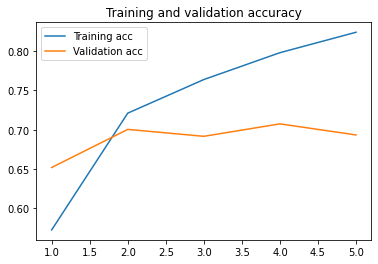

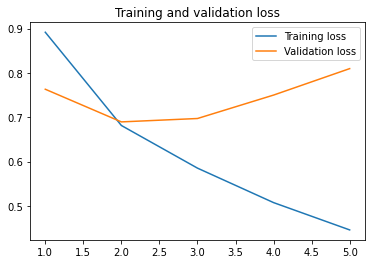

In [29]:
import matplotlib.pyplot as plt

acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss,label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [30]:
model.save("tweetModel.h5")

In [36]:
pred = model.predict(X_test)
pred

array([[0.98191917, 0.01051906, 0.00756174],
       [0.01699852, 0.00695681, 0.97604465],
       [0.02876944, 0.03995042, 0.93128014],
       ...,
       [0.00385867, 0.3601306 , 0.6360107 ],
       [0.00248227, 0.10664253, 0.89087516],
       [0.5373074 , 0.03182727, 0.43086532]], dtype=float32)

In [37]:
y_test

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

#Model evaluation

Confusion matrix: 
[[328  20  94]
 [ 33 293 156]
 [ 69  46 379]]
Prediction Accuracy: 
Accuracy of Positive class in % : 
74.2081447963801
Accuracy of Negative class in %: 
60.788381742738586
Accuracy of Neutral class in %
76.72064777327935


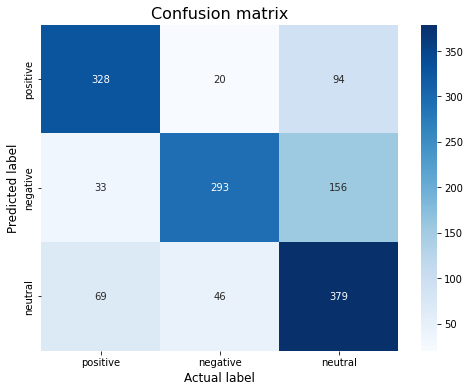

In [38]:
from modelutility import confusionMatrix
confusionMatrix(model, X_test, y_test)

In [41]:
txt = ['had a wonderful experience at your airline']
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tok = Tokenizer(num_words = most_common,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tok.fit_on_texts(data.text.values)
sequences = tok.texts_to_sequences(data.text.values)
word_index = tok.word_index
X_data = pad_sequences(sequences, maxlen = max_len)


In [42]:
seq = tok.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['positive', 'negative','neutral']
print(pred, labels[np.argmax(pred)])

[[9.9866843e-01 1.2820998e-03 4.9492010e-05]] positive


In [43]:
txt = ['@VirginAmerica heyyyy guyyyys.. been trying to get through for an hour. can someone call me please? :/']
seq = tok.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['positive', 'negative','neutral']
print(pred, labels[np.argmax(pred)])

[[0.00279338 0.62334037 0.37386626]] negative


In [44]:
txt = ['@JetBlue: @dlewis2412 Sorry! Please ask Inflght if there is an open seat you can move to.” Will do!']
seq = tok.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['positive', 'negative','neutral']
print(pred, labels[np.argmax(pred)])

[[0.0177342  0.06865624 0.9136096 ]] neutral


#Load Model

In [47]:
model2 = tensorflow.keras.models.load_model('tweetModel.h5')

In [48]:
txt = ['@JetBlue: @dlewis2412 Sorry! Please ask Inflght if there is an open seat you can move to.” Will do!']
seq = tok.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model2.predict(padded)
labels = ['positive', 'negative','neutral']
print(pred, labels[np.argmax(pred)])

[[0.0177342  0.06865624 0.9136096 ]] neutral


In [49]:
txt = ['@VirginAmerica heyyyy guyyyys.. been trying to get through for an hour. can someone call me please? :/']
seq = tok.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model2.predict(padded)
labels = ['positive', 'negative','neutral']
print(pred, labels[np.argmax(pred)])

[[0.00279338 0.62334037 0.37386626]] negative


In [50]:
txt = ['had a wonderful experience at your airline']
seq = tok.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['positive', 'negative','neutral']
print(pred, labels[np.argmax(pred)])

[[9.9866843e-01 1.2820998e-03 4.9492010e-05]] positive
